In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_csv_with_headers(filepath):

    df = pd.read_csv(filepath, names=['Policy', 'environment', 'mean', 'std'])
    if df.columns[0] != 'Policy':
        df.columns = ['Policy', 'environment', 'mean', 'std']

    df['mean'] = df['mean'].abs()  # Change negative values to positive
    df['environment'] = df['environment'].str.strip()  # Remove leading and trailing whitespaces
    df = calculate_confidence_interval(df)
    return df

def calculate_confidence_interval(df):
    df['CI'] = 1.96 * df['std'] / np.sqrt(500)
    return df

In [2]:
data = {}

configs = ["slow_server", "n_system", "down_stream", "high_utilization", "low_utilization", "parallel", "single_activity"]

for config in configs:
    df = read_csv_with_headers(f"./results/smdp/results_{config}.txt")
    policies = ['Greedy', 'Random', 'FIFO']
    if config == 'single_activity':
        policies.append('Threshold')
    for policy in policies:
        df_policy = df[df['Policy'] == policy]
        data[policy] = (df_policy['mean'].iloc[0], df_policy['CI'].iloc[0])

    for environment in ['smdp', 'mdp']:
        for v in [f'v{i}' for i in range(1, 11)]:
            #print(v, environment, v in df['Policy'].unique(), environment in df['environment'].unique())
            #print(df)
            df_learned_v = df[(df['environment'] == environment) & (df['Policy'] == v)]
            data[(environment, v)] = (df_learned_v['mean'].iloc[0], df_learned_v['CI'].iloc[0])

    # Create figure
    fig, ax = plt.subplots(figsize=(15, 6))

    # Setup x-axis positions
    versions = [f'v{i}' for i in range(1, 11)]
    width = 0.35

    # Calculate x positions
    policy_positions = np.arange(len(policies))
    version_positions = np.arange(len(versions)) + len(policies)  # +1 for spacing

    # Plot policies
    policy_means = [data[p][0] for p in policies]
    policy_errors = [data[p][1] for p in policies]
    ax.bar(policy_positions, policy_means, yerr=policy_errors, capsize=5, label='Benchmark heuristics')

    # Plot learned models
    smdp_means = [data[('smdp', v)][0] for v in versions]
    smdp_errors = [data[('smdp', v)][1] for v in versions]
    mdp_means = [data[('mdp', v)][0] for v in versions]
    mdp_errors = [data[('mdp', v)][1] for v in versions]

    ax.bar(version_positions - width/2, smdp_means, width, yerr=smdp_errors, label='SMDP', capsize=5)
    ax.bar(version_positions + width/2, mdp_means, width, yerr=mdp_errors, label='MDP', capsize=5)

    ax.axhline(y=min(policy_means), color='black', linestyle='--', label='Best benchmark heuristic')
    ax.set_ylim(0, 1.2 * max(policy_means))

    # Set x-ticks and labels
    all_positions = np.concatenate([policy_positions, version_positions])
    all_labels = policies + versions
    ax.set_xticks(all_positions)
    ax.set_xticklabels(all_labels)

    # Add labels and legend
    ax.set_ylabel('Value')
    ax.set_title(f'Performance Comparison for {config}')
    ax.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './results/smdp/results_slow_server.txt'

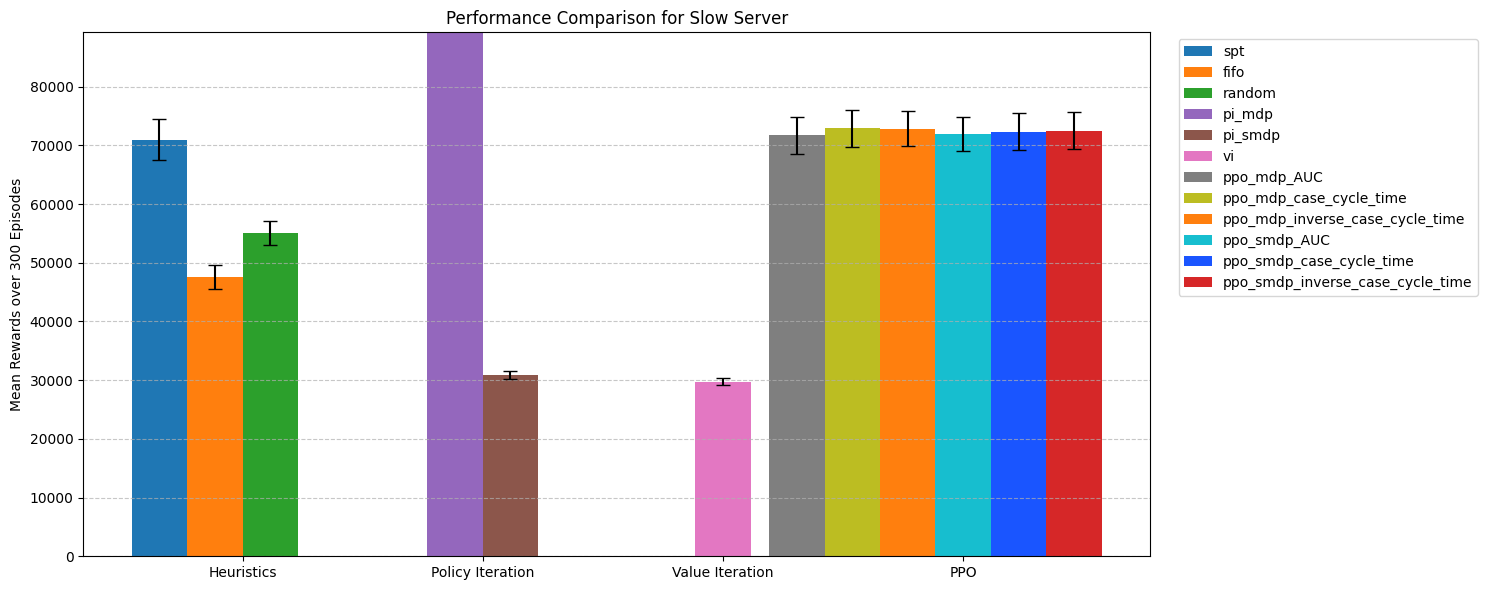

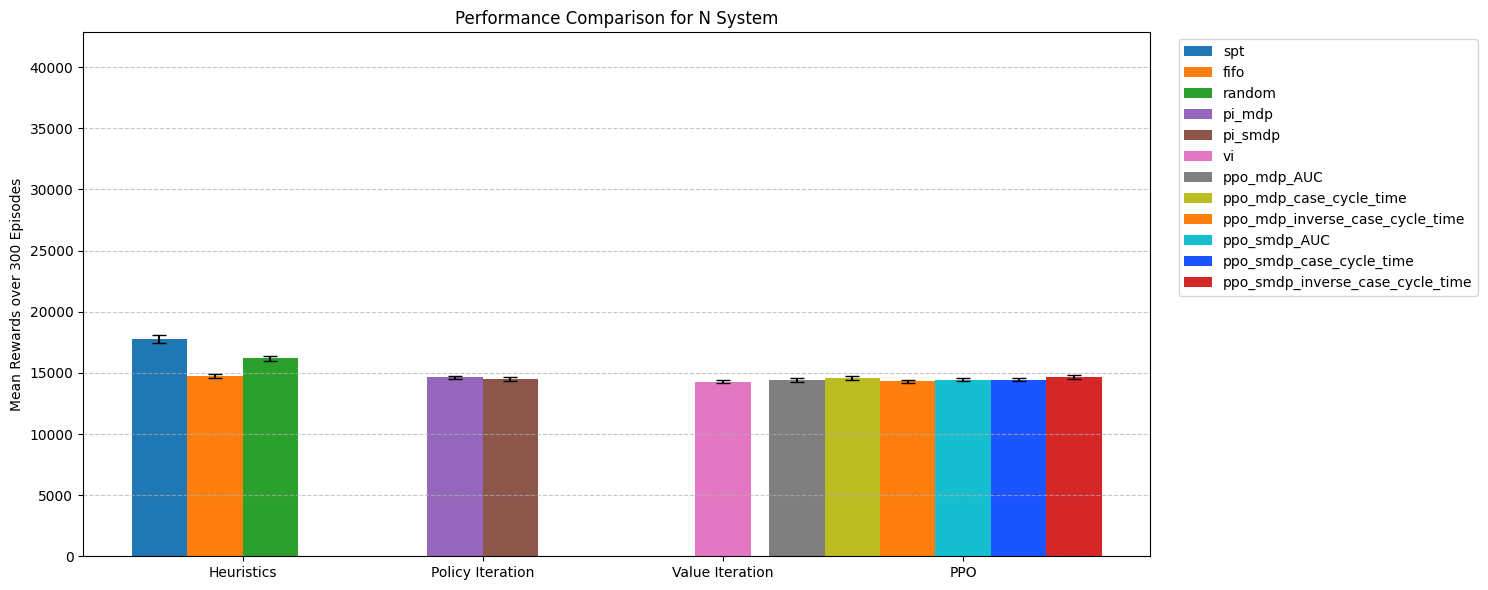

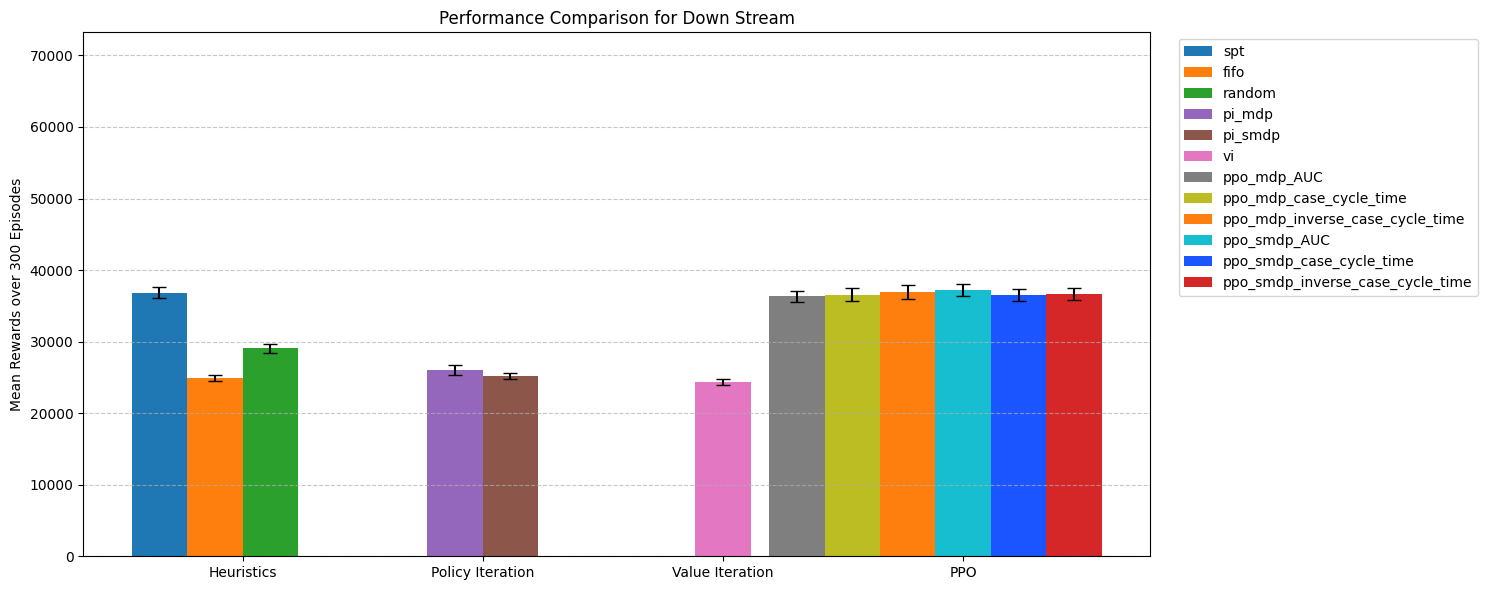

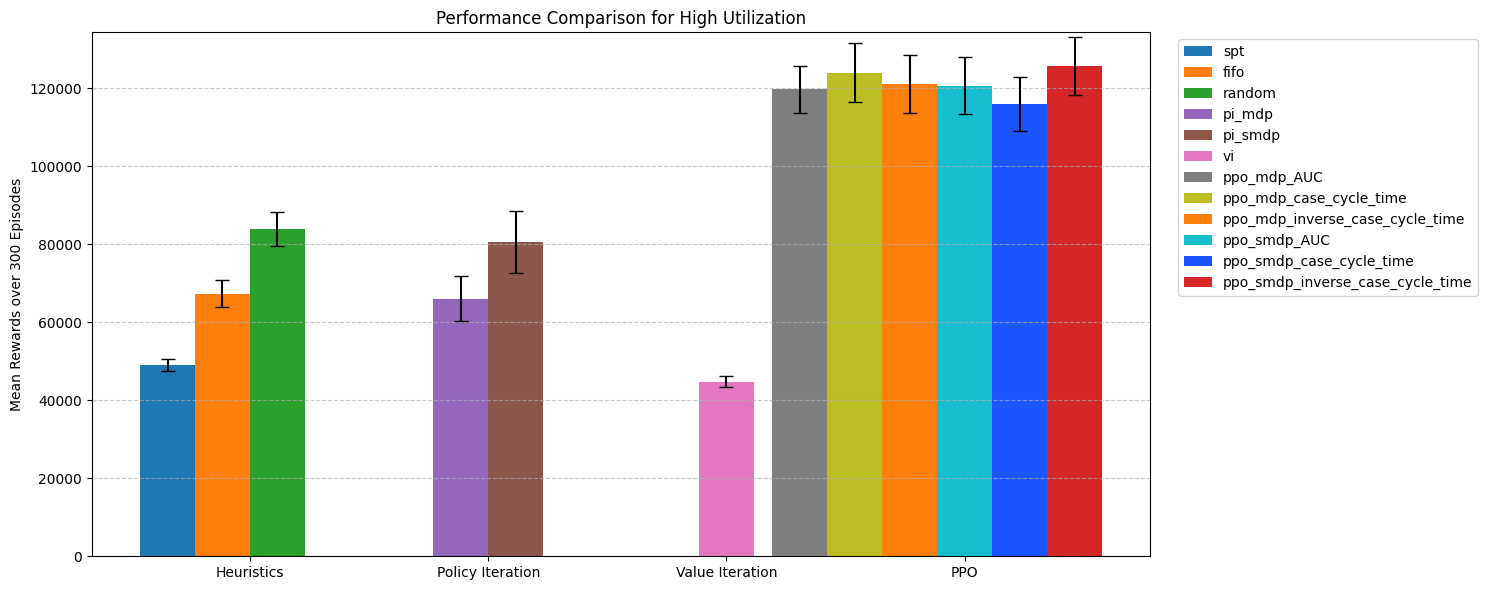

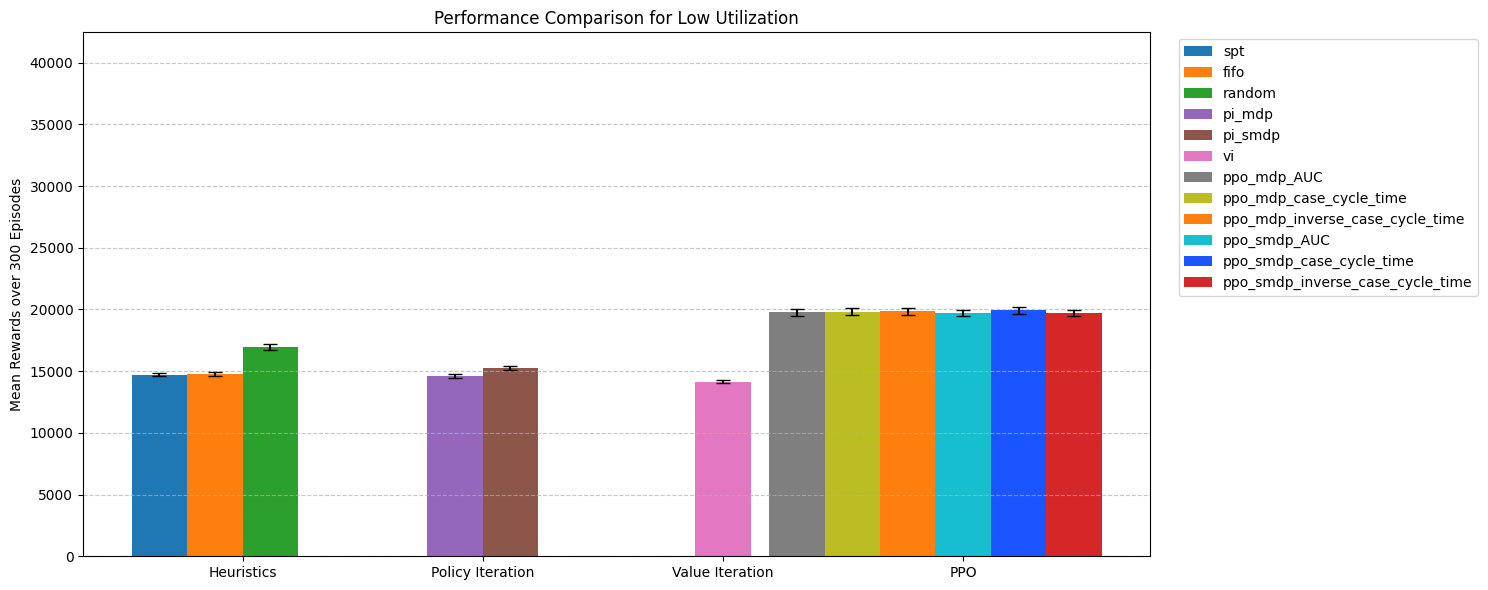

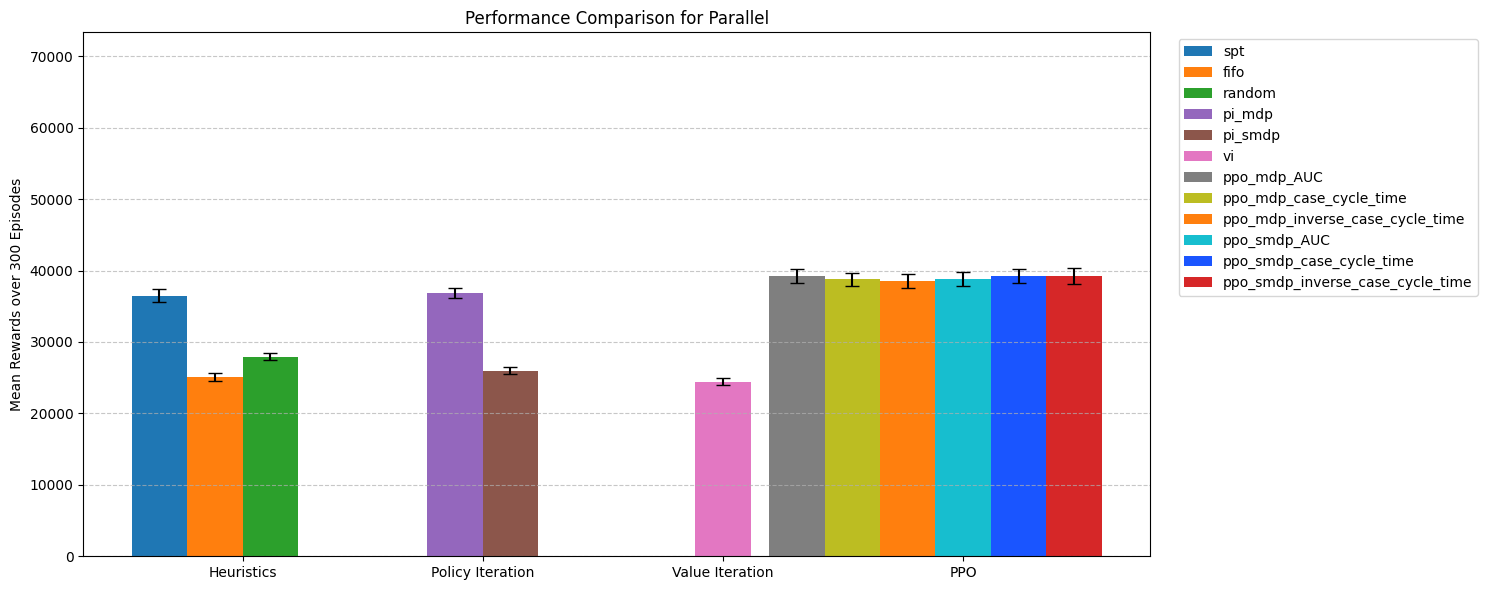

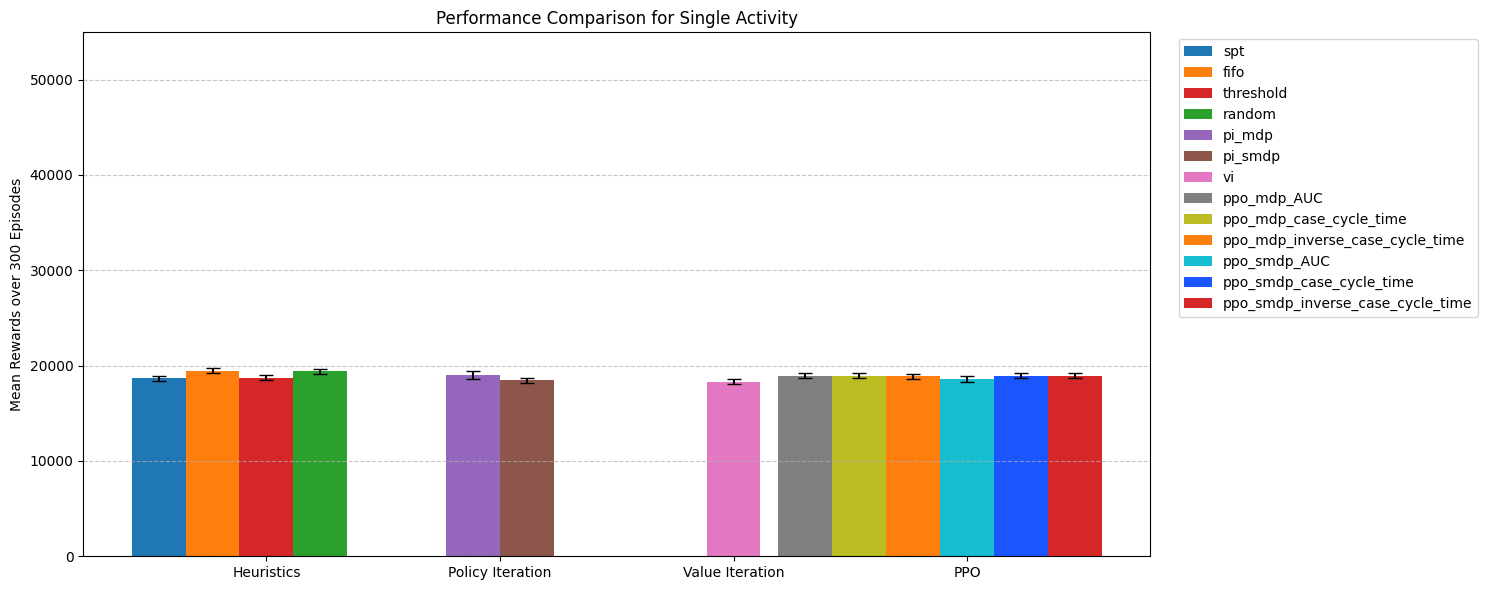

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_csv_with_headers(filepath):
    df = pd.read_csv(filepath, names=['mean', 'std'])
    df['mean'] = df['mean'].abs()  # Change negative values to positive
    df = calculate_confidence_interval(df)
    return df

def calculate_confidence_interval(df):
    df['CI'] = 1.96 * df['std'] / np.sqrt(300)
    return df

data = {}

configs = ["slow_server", "n_system", "down_stream", "high_utilization", "low_utilization", "parallel", "single_activity"]

for config in configs:
    for env_type in ['mdp', 'smdp']:
        # PPO results
        for reward_function in ['AUC', 'case_cycle_time', 'inverse_case_cycle_time']:
            df = pd.read_csv(f"./results/ppo_{env_type}_{reward_function}_{config}.txt")
            mean = abs(df['mean'].iloc[0])
            std = df['std'].iloc[0]
            ci = 1.96 * std / np.sqrt(300)
            data[f'ppo_{env_type}_{reward_function}'] = (mean, ci)
        
        # Policy Iteration results
        df = pd.read_csv(f"./results/pi_{env_type}_{config}.txt")
        mean = abs(df['mean'].iloc[0])
        std = df['std'].iloc[0]
        ci = 1.96 * std / np.sqrt(300)
        data[f'pi_{env_type}'] = (mean, ci)

    # Value Iteration results
    df = pd.read_csv(f"./results/vi_{config}.txt")
    mean = abs(df['mean'].iloc[0])
    std = df['std'].iloc[0]
    ci = 1.96 * std / np.sqrt(300)
    data[f'vi'] = (mean, ci)

    # Heuristics
    if config == 'single_activity':
        heuristics = ['spt', 'fifo', 'threshold', 'random']
    else:
        heuristics = ['spt', 'fifo', 'random']
    for heuristic in heuristics:
        df = pd.read_csv(f"./results/{heuristic}_{config}.txt")
        mean = abs(df['mean'].iloc[0])
        std = df['std'].iloc[0]
        ci = 1.96 * std / np.sqrt(300)
        data[heuristic] = (mean, ci)

    plt.style.use('default')
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Setup group positions
    n_groups = 4
    group_width = 0.15
    bar_width = 0.15
    group_positions = np.arange(n_groups) * (group_width + 0.5)
    
    # Define color schemes
    heuristic_colors = {
        'spt': '#1f77b4',     # blue
        'fifo': '#ff7f0e',    # orange
        'random': '#2ca02c',   # green
        'threshold': '#d62728' # red
    }
    
    pi_colors = {
        'pi_mdp': '#9467bd',   # purple
        'pi_smdp': '#8c564b'   # brown
    }
    
    vi_color = '#e377c2'       # pink
    
    ppo_colors = {
        'ppo_mdp_AUC': '#7f7f7f',             # gray
        'ppo_mdp_case_cycle_time': '#bcbd22',  # yellow-green
        'ppo_mdp_inverse_case_cycle_time': '#ff7f0e',  # orange
        'ppo_smdp_AUC': '#17becf',            # cyan
        'ppo_smdp_case_cycle_time': '#1a55FF',  # blue
        'ppo_smdp_inverse_case_cycle_time': '#d62728'  # red
    }
    
    # Plot heuristic group
    for i, heuristic in enumerate(heuristics):
        offset = (i - len(heuristics)/2) * bar_width
        ax.bar(group_positions[0] + offset, data[heuristic][0], bar_width, 
               yerr=data[heuristic][1], label=heuristic, 
               color=heuristic_colors[heuristic], error_kw={'capsize': 5})
    
    # Plot PI group
    pi_labels = ['pi_mdp', 'pi_smdp']
    for i, pi in enumerate(pi_labels):
        offset = (i - 0.5) * bar_width
        ax.bar(group_positions[1] + offset, data[pi][0], bar_width,
               yerr=data[pi][1], label=pi, 
               color=pi_colors[pi], error_kw={'capsize': 5})
    
    # Plot VI group
    ax.bar(group_positions[2], data['vi'][0], bar_width,
           yerr=data['vi'][1], label='vi', 
           color=vi_color, error_kw={'capsize': 5})
    
    # Plot PPO group
    ppo_labels = ['ppo_mdp_AUC', 'ppo_mdp_case_cycle_time', 'ppo_mdp_inverse_case_cycle_time',
                  'ppo_smdp_AUC', 'ppo_smdp_case_cycle_time', 'ppo_smdp_inverse_case_cycle_time']
    for i, ppo in enumerate(ppo_labels):
        offset = (i - len(ppo_labels)/2) * bar_width
        ax.bar(group_positions[3] + offset, data[ppo][0], bar_width,
               yerr=data[ppo][1], label=ppo, 
               color=ppo_colors[ppo], error_kw={'capsize': 5})

    
    # Customize plot
    ax.set_xticks(group_positions)
    ax.set_xticklabels(['Heuristics', 'Policy Iteration', 'Value Iteration', 'PPO'])
    ax.set_ylabel('Mean Rewards over 300 Episodes')
    ax.set_title(f'Performance Comparison for {config.replace("_", " ").title()}')
    ax.yaxis.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust legend and layout
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax.set_ylim(0,3 * min([data[d][0] for d in data]))
    plt.tight_layout()
    
    plt.show()

# Plot best results

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

policies = ['spt', 'fifo', 'random', 'threshold', 'ppo', 'pi', 'vi']
scenarios = ['slow_server', 'n_system', 'down_stream', 'high_utilization', 'low_utilization', 'parallel', 'single_activity']

for scenario in scenarios:
    df_spt = pd.read_csv(f'.results/spt_{scenario}.txt')
    df_fifo = pd.read_csv(f'.results/fifo_{scenario}.txt')
    df_random = pd.read_csv(f'.results/random_{scenario}.txt')
    if scenario == 'single_activity':
        df_threshold = pd.read_csv(f'.results/threshold_{scenario}.txt')
    df_ppo_smdp = pd.read_csv(f'.results/ppo_{scenario}_smdp.txt')
    df_ppo_mdp = pd.read_csv(f'.results/ppo_{scenario}_mdp.txt')
    df_pi_smdp = pd.read_csv(f'.results/pi_{scenario}_smdp.txt')
    df_pi_mdp = pd.read_csv(f'.results/pi_{scenario}_mdp.txt')
    df_vi = pd.read_csv(f'.results/vi_{scenario}.txt')

AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)